<a id='plotting'></a>
# Step 1: Visualization and Analysis

This notebook is dedicated to processing and visualizing the output of the C-language geodesic integrator. The cells here are for analysis and are not part of the C code generation process. They are designed to be run *after* the C code has been compiled and executed, and has produced a `light_blueprint.bin` file.

The Python code below uses standard libraries like `numpy`, `matplotlib`, and `Pillow` to:
1.  Define a `numpy` data type that exactly matches the binary format of the `blueprint_data_t` C struct.
2.  Load the binary `light_blueprint.bin` file into a structured `numpy` array.
3.  Perform statistical analysis on the ray-tracing results.
4.  Generate a variety of plots, including false-color images of the lensed accretion disk and histograms of the data.

**Notebook Status:** <font color='green'><b>Validated</b></font>

<a id='blueprint_dtype'></a>
## 1.a: Defining the Blueprint Data Structure

Before we can read the binary output file from our C code, we must tell Python exactly what the structure of the data is. The `light_blueprint.bin` file is not a standard image file; it is a raw binary dump of the `blueprint_data_t` C structs, one after another.

This cell defines a `numpy` structured data type (`dtype`) that precisely mirrors the C struct. Each field is given a name (e.g., `'termination_type'`), a data type (e.g., `np.int32` for a 32-bit integer), and a size. This `BLUEPRINT_DTYPE` acts as a template, allowing `numpy` to correctly parse the binary file into a structured array, making the data easily accessible in Python.

In [1]:
import numpy as np
from PIL import Image
from typing import Union, Optional, List, Tuple
import os

# Define the exact structure of a record in the new light_blueprint.bin file.
# This must match the final C struct 'blueprint_data_t'.
BLUEPRINT_DTYPE = np.dtype([
    ('termination_type', np.int32),
    ('y_w', 'f8'), 
    ('z_w', 'f8'),
    # Fields for DISK hits
    ('stokes_I', 'f8'),
    ('lambda_observed', 'f8'),
    # Fields for SOURCE PLANE hits
    ('y_s', 'f8'),
    ('z_s', 'f8'),
    # Fields for CELESTIAL SPHERE hits
    ('final_theta', 'f8'),
    ('final_phi', 'f8'),
    # Diagnostic fields
    ('L_w', 'f8'),
    ('t_w', 'f8'),
    ('L_s', 'f8'),
    ('t_s', 'f8'),
], align=False)

print("Libraries and new blueprint data type (BLUEPRINT_DTYPE) defined.")

Libraries and new blueprint data type (BLUEPRINT_DTYPE) defined.


<a id='debug_plot'></a>
## 1.b: Debug Trajectory Visualizer

When debugging the integrator, it is often useful to trace the path of a single photon. When the C code is run in `debug_mode`, it outputs a text file (`photon_path.txt`) containing the full trajectory (position and momentum) of a single ray at each step of the GSL integrator.

The function `plot_photon_trajectory_from_debug` reads this text file and generates a 3D plot of the photon's path through spacetime. It also plots a sphere at the origin representing the black hole's event horizon to provide a visual reference. This is an invaluable tool for diagnosing issues with the integrator or for gaining intuition about how geodesics behave in curved spacetime.

### Function: `plot_photon_trajectory_from_debug()`
*   **Inputs:**
    *   `project_dir`: The path to the C project directory.
    *   `input_filename`: The name of the debug trajectory file to read.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D

def plot_photon_trajectory_from_debug(
    project_dir: str = "project/photon_geodesic_integrator",
    input_filename: str = "photon_path_numerical.txt"
) -> None:
    """
    Reads trajectory data from the C code's debug output and generates a
    simple 3D plot of the photon's path with a sphere at the origin.
    """
    print("--- Generating Photon Trajectory Plot from Debug File ---")
    
    # --- 1. Construct the full path and load the data ---
    full_path = os.path.join(project_dir, input_filename)
    
    if not os.path.exists(full_path):
        print(f"ERROR: Trajectory file not found at '{full_path}'")
        print("Please ensure you have compiled and run the C code in debug mode successfully.")
        return

    try:
        # Load the data, skipping the header row.
        # Set invalid_raise=False to handle potential trailing empty lines.
        data = np.loadtxt(full_path, skiprows=1, ndmin=2)
        if data.shape[0] == 0:
            print("ERROR: Trajectory file is empty.")
            return
            
        # Columns: 0:lambda, 1:t, 2:x, 3:y, 4:z, ...
        x_coords = data[:, 2]
        y_coords = data[:, 3]
        z_coords = data[:, 4]
        print(f"Successfully loaded {len(x_coords)} data points from trajectory file.")
    except Exception as e:
        print(f"ERROR: Failed to load or parse the data file '{full_path}'.")
        print(f"Exception: {e}")
        return

    # --- 2. Set up the 3D plot ---
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # --- 3. Plot the photon's trajectory ---
    ax.plot(x_coords, y_coords, z_coords, label='Photon Path', color='cyan', lw=2)
    
    # Mark the start (camera) and end points
    ax.scatter(x_coords[0], y_coords[0], z_coords[0], color='lime', s=100, label='Start (Camera)', marker='o', depthshade=False)
    ax.scatter(x_coords[-1], y_coords[-1], z_coords[-1], color='red', s=100, label='End Point', marker='X', depthshade=False)

    # --- 4. Plot a simple sphere at the origin ---
    radius = 2.0 # Represents r=2M, the Schwarzschild event horizon
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_bh = radius * np.outer(np.cos(u), np.sin(v))
    y_bh = radius * np.outer(np.sin(u), np.sin(v))
    z_bh = radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_bh, y_bh, z_bh, color='grey', alpha=0.5, rstride=5, cstride=5)
    
    # --- 5. Customize the plot ---
    ax.set_xlabel('X (M)', fontsize=12, labelpad=10)
    ax.set_ylabel('Y (M)', fontsize=12, labelpad=10)
    ax.set_zlabel('Z (M)', fontsize=12, labelpad=10)
    
    # Set aspect ratio to be equal to avoid distortion
    max_range = np.array([x_coords.max()-x_coords.min(), y_coords.max()-y_coords.min(), z_coords.max()-z_coords.min()]).max() / 2.0
    if max_range == 0: max_range = np.max(np.abs(data[:, 2:5]))
    mid_x = (x_coords.max()+x_coords.min()) * 0.5
    mid_y = (y_coords.max()+y_coords.min()) * 0.5
    mid_z = (z_coords.max()+z_coords.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_title("Photon Trajectory (Debug Run)", fontsize=16)
    ax.legend()
    ax.view_init(elev=15, azim=60)
    
    plt.show()


<a id='blueprint_inspector'></a>
## 1.c: Blueprint Data Inspector

The `light_blueprint.bin` file contains a wealth of information. This cell defines the `view_binary_blueprint` function, a utility for quickly inspecting the raw contents of the blueprint file.

It reads the binary file using the `BLUEPRINT_DTYPE` template and prints a formatted table showing a sample of the records. For each ray, it displays its termination type and the key physical results associated with that termination (e.g., the observed intensity for a disk hit, or the final angles for a celestial sphere hit). This is a useful first step for verifying that the C code is producing sensible output.

### Function: `view_binary_blueprint()`
*   **Inputs:**
    *   `blueprint_filename`: The path to the `light_blueprint.bin` file.
    *   `max_rays_to_print`: The number of sample records to display.

In [3]:
import numpy as np
import os

def view_binary_blueprint(
    blueprint_filename="project/photon_geodesic_integrator/light_blueprint.bin",
    max_rays_to_print=20
):
    """
    Reads the new binary blueprint file and prints its raw contents in a
    human-readable, context-aware format.
    
    UPDATED to understand the new, detailed termination_type_t enum.
    """
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    # This function now uses the global BLUEPRINT_DTYPE defined in the previous cell.
    data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    
    print(f"--- Raw Blueprint Data Inspector (Debug-Enabled Version) ---")
    print(f"Total records read from file: {len(data)}\n")
    print("Printing a sample of records...")
    
    # --- UPDATED ENUM MAPPING ---
    # This map now reflects the exact integer values from your requested C enum.
    term_str_map = {
        0: "FAIL_PT_BIG", 1: "DISK", 2: "SOURCE_PLANE", 3: "SPHERE",
        4: "ACTIVE", 5: "FAIL_GSL", 6: "FAIL_GENERIC",
        7: "FAIL_T_MAX", 8: "FAIL_SLOT"
    }
    print("Enum Mapping:", ", ".join([f"{k}={v}" for k, v in term_str_map.items()]))
    
    # Updated header for new data fields
    header = f"{'Ray#':<8} | {'TermType':<12} | {'y_w':>8} | {'z_w':>8} | {'Result 1':>12} | {'Result 2':>12}"
    print(header)
    print("-" * len(header))

    if len(data) > max_rays_to_print:
        indices_to_print = np.linspace(0, len(data) - 1, max_rays_to_print, dtype=int)
    else:
        indices_to_print = np.arange(len(data))

    for i in indices_to_print:
        rec = data[i]
        term_type = int(rec['termination_type'])
        term_str = term_str_map.get(term_type, "UNKNOWN")

        res1_str, res2_str = "N/A", "N/A"
        if term_type == 1: # DISK
            res1_str = f"I={rec['stokes_I']:.3e}"
            res2_str = f"λ={rec['lambda_observed']:.2f}"
        elif term_type == 2: # SOURCE_PLANE
            res1_str = f"y_s={rec['y_s']:.3f}"
            res2_str = f"z_s={rec['z_s']:.3f}"
        elif term_type == 3: # CELESTIAL_SPHERE
            res1_str = f"θ={rec['final_theta']:.3f}"
            res2_str = f"φ={rec['final_phi']:.3f}"
        
        print(f"{i:<8} | {term_str:<12} | {rec['y_w']:>8.2f} | {rec['z_w']:>8.2f} | {res1_str:>12} | {res2_str:>12}")

<a id='blueprint_analyzer'></a>
## 1.d: Comprehensive Blueprint Analysis and Visualization

This cell defines the `analyze_blueprint` function, which performs a comprehensive statistical analysis of the entire ray-tracing run and generates a suite of plots to visualize the results.

The function first loads the entire `light_blueprint.bin` file and segregates the data based on how each ray terminated. It then calculates and prints summary statistics for each outcome, such as the apparent size of the black hole shadow and the range of observed intensities and wavelengths for disk hits.

Finally, it generates a multi-panel figure that provides a deep dive into the simulation results:
*   **Observed Intensity Map**: A 2D histogram showing the brightness of the accretion disk as seen on the camera's window plane.
*   **Observed Wavelength Map**: A scatter plot showing the color (Doppler and gravitational redshift/blueshift) of the disk.
*   **Wavelength vs. Radius**: A plot showing the relationship between the observed wavelength and the apparent radius on the camera's window, often revealing the characteristic signature of a rotating disk.
*   **Intensity Distribution**: A histogram of the observed intensities.
*   **Termination Pie Chart**: A chart showing the percentage of rays that hit the disk, the shadow, the source plane, etc.
*   **Outcome by Radius**: A stacked histogram showing what happened to photons as a function of their starting radial position on the camera's window.

### Function: `analyze_blueprint()`
*   **Inputs:**
    *   `blueprint_filename`: The path to the `light_blueprint.bin` file.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

def analyze_blueprint(blueprint_filename="project/photon_geodesic_integrator/light_blueprint.bin"):
    """
    Reads the blueprint file and generates a comprehensive statistical analysis
    and a full suite of plots.
    
    UPDATED Plot 5 to show a breakdown of failure types in the stacked histogram.
    """
    # --- 1. Load Data ---
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    try:
        data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    except NameError:
        print("ERROR: BLUEPRINT_DTYPE is not defined. Please run the cell that defines it first.")
        return
        
    if len(data) == 0:
        print("Blueprint file is empty. No analysis to perform.")
        return

    # --- 2. Segregate Data by Termination Type (UPDATED for new enum) ---
    disk_hits = data[data['termination_type'] == 1]
    source_plane_hits = data[data['termination_type'] == 2]
    sphere_hits = data[data['termination_type'] == 3]
    fail_pt_big_hits = data[data['termination_type'] == 0]
    fail_gsl_hits = data[data['termination_type'] == 5]
    fail_generic_hits = data[data['termination_type'] == 6]
    fail_t_max_hits = data[data['termination_type'] == 7]
    fail_slot_hits = data[data['termination_type'] == 8]
    all_failure_hits = np.concatenate([
        fail_pt_big_hits, fail_gsl_hits, fail_generic_hits,
        fail_t_max_hits, fail_slot_hits
    ])
    num_total_rays = len(data)
    num_disk = len(disk_hits)
    num_source_plane = len(source_plane_hits)
    num_sphere = len(sphere_hits)
    num_total_failure = len(all_failure_hits)

    print("--- Blueprint File Analysis (Debug-Enabled Version) ---")
    print(f"Total rays in scan: {num_total_rays}")
    print(f"  Rays that hit the DISK:              {num_disk} ({100.0 * num_disk / num_total_rays:.2f}%)")
    print(f"  Rays that hit the SOURCE_PLANE:      {num_source_plane} ({100.0 * num_source_plane / num_total_rays:.2f}%)")
    print(f"  Rays that hit the CELESTIAL_SPHERE:  {num_sphere} ({100.0 * num_sphere / num_total_rays:.2f}%)")
    print(f"  TOTAL FAILED RAYS (shadow):          {num_total_failure} ({100.0 * num_total_failure / num_total_rays:.2f}%)")

    if num_total_failure > 0:
        print("    --- Failure Breakdown ---")
        print(f"    -> GSL Integrator Error:      {len(fail_gsl_hits)} ({100.0 * len(fail_gsl_hits) / num_total_failure:.2f}%)")
        print(f"    -> |p^t| Exceeded Max:        {len(fail_pt_big_hits)} ({100.0 * len(fail_pt_big_hits) / num_total_failure:.2f}%)")
        print(f"    -> Integration Time Exceeded: {len(fail_t_max_hits)} ({100.0 * len(fail_t_max_hits) / num_total_failure:.2f}%)")
        print(f"    -> Slot Manager Error:        {len(fail_slot_hits)} ({100.0 * len(fail_slot_hits) / num_total_failure:.2f}%)")
        print(f"    -> Generic Failure:           {len(fail_generic_hits)} ({100.0 * len(fail_generic_hits) / num_total_failure:.2f}%)")
        
        r_w_failure = np.sqrt(all_failure_hits['y_w']**2 + all_failure_hits['z_w']**2)
        if len(r_w_failure) > 0 and np.any(np.isfinite(r_w_failure)):
            print(f"    -> Apparent radius of black hole shadow on window: {np.nanmax(r_w_failure):.4f} M")

    print("-" * 60)

    # --- 3. Detailed Statistical Analysis ---
    if num_disk > 0:
        valid_disk_hits = disk_hits[np.isfinite(disk_hits['stokes_I']) & np.isfinite(disk_hits['lambda_observed'])]
        if len(valid_disk_hits) > 0:
            intensities = valid_disk_hits['stokes_I']
            wavelengths = valid_disk_hits['lambda_observed']
            print("\n--- Detailed Disk Hit Statistics ---")
            print("\n  Observed Intensity (Stokes I):")
            print(f"    Min / Max:    {np.min(intensities):.3e} / {np.max(intensities):.3e}")
            print(f"    Mean / Median:  {np.mean(intensities):.3e} / {np.median(intensities):.3e}")
            percentiles_I = np.percentile(intensities, [10, 25, 75, 90])
            print(f"    Percentiles:  10th={percentiles_I[0]:.3e}, 25th={percentiles_I[1]:.3e}, 75th={percentiles_I[2]:.3e}, 90th={percentiles_I[3]:.3e}")

            print("\n  Observed Wavelength (lambda_obs) in nm:")
            print(f"    Min / Max:    {np.min(wavelengths):.2f} / {np.max(wavelengths):.2f}")
            print(f"    Mean / Median:  {np.mean(wavelengths):.2f} / {np.median(wavelengths):.2f}")
            percentiles_L = np.percentile(wavelengths, [10, 25, 75, 90])
            print(f"    Percentiles:  10th={percentiles_L[0]:.2f}, 25th={percentiles_L[1]:.2f}, 75th={percentiles_L[2]:.2f}, 90th={percentiles_L[3]:.2f}")

    if num_source_plane > 0:
        valid_plane_hits = source_plane_hits[np.isfinite(source_plane_hits['y_s']) & np.isfinite(source_plane_hits['z_s'])]
        if len(valid_plane_hits) > 0:
            r_s = np.sqrt(valid_plane_hits['y_s']**2 + valid_plane_hits['z_s']**2)
            print("\n--- Source Plane Hit Statistics ---")
            print(f"  Planar Radius (r_s) for these hits: min={np.min(r_s):.4f}, max={np.max(r_s):.4f}, mean={np.mean(r_s):.4f}")
            print(f"  Intersection Time (t_s) for these hits: min={np.min(valid_plane_hits['t_s']):.2f}, max={np.max(valid_plane_hits['t_s']):.2f}, mean={np.mean(valid_plane_hits['t_s']):.2f}")

    if num_sphere > 0:
        valid_sphere_hits = sphere_hits[np.isfinite(sphere_hits['final_theta']) & np.isfinite(sphere_hits['final_phi'])]
        if len(valid_sphere_hits) > 0:
            print("\n--- Celestial Sphere Hit Statistics ---")
            print(f"  Final Angle (theta) for these hits: min={np.min(valid_sphere_hits['final_theta']):.4f}, max={np.max(valid_sphere_hits['final_theta']):.4f}, mean={np.mean(valid_sphere_hits['final_theta']):.4f}")
            print(f"  Final Angle (phi)   for these hits: min={np.min(valid_sphere_hits['final_phi']):.4f}, max={np.max(valid_sphere_hits['final_phi']):.4f}, mean={np.mean(valid_sphere_hits['final_phi']):.4f}")

    # --- 4. Generate Expanded Plots (3x2 Grid) ---
    fig, axes = plt.subplots(3, 2, figsize=(22, 27))
    fig.suptitle("Blueprint Data Visualization (Debug-Enabled, Robust Plotting)", fontsize=20)
    ax = axes.ravel()

    # Plot 0: Observed Intensity (Stokes I) on Window
    if num_disk > 0 and 'valid_disk_hits' in locals() and len(valid_disk_hits) > 0:
        plot_data_I = valid_disk_hits[valid_disk_hits['stokes_I'] > 0]
        if len(plot_data_I) > 0:
            hist = ax[0].hist2d(plot_data_I['y_w'], plot_data_I['z_w'], 
                                bins=256, cmap='inferno', norm=LogNorm(),
                                weights=plot_data_I['stokes_I'])
            ax[0].set_title("Observed Intensity (Stokes I) on Window Plane")
            ax[0].set_xlabel("y_w (M)"); ax[0].set_ylabel("z_w (M)")
            ax[0].set_aspect('equal', 'box')
            fig.colorbar(hist[3], ax=ax[0], label="Intensity")
        else:
            ax[0].text(0.5, 0.5, "No Positive Intensity Hits", ha='center', va='center', fontsize=16)
            ax[0].set_title("Observed Intensity (Stokes I)")
    else:
        ax[0].text(0.5, 0.5, "No Disk Hits", ha='center', va='center', fontsize=16)
        ax[0].set_title("Observed Intensity (Stokes I)")

    # Plot 1: Observed Wavelength on Window
    if num_disk > 0 and 'valid_disk_hits' in locals() and len(valid_disk_hits) > 0:
        if len(valid_disk_hits['lambda_observed']) > 0:
            lambda_min = np.min(valid_disk_hits['lambda_observed'])
            lambda_max = np.max(valid_disk_hits['lambda_observed'])
            if lambda_min >= lambda_max:
                lambda_max = lambda_min + 1e-9
            
            sc = ax[1].scatter(valid_disk_hits['y_w'], valid_disk_hits['z_w'], 
                               c=valid_disk_hits['lambda_observed'], cmap='jet', s=2, vmin=lambda_min, vmax=lambda_max)
            ax[1].set_title("Observed Wavelength (λ_obs) on Window Plane")
            ax[1].set_xlabel("y_w (M)"); ax[1].set_ylabel("z_w (M)")
            ax[1].set_aspect('equal', 'box')
            ax[1].set_facecolor('black')
            fig.colorbar(sc, ax=ax[1], label="Wavelength (nm)")
        else:
            ax[1].text(0.5, 0.5, "No Valid Wavelength Data", ha='center', va='center', fontsize=16)
            ax[1].set_title("Observed Wavelength (λ_obs)")
    else:
        ax[1].text(0.5, 0.5, "No Disk Hits", ha='center', va='center', fontsize=16)
        ax[1].set_title("Observed Wavelength (λ_obs)")

    # Plot 2: Observed Wavelength vs. WINDOW Radius
    if num_disk > 0 and 'valid_disk_hits' in locals() and len(valid_disk_hits) > 0:
        r_w = np.sqrt(valid_disk_hits['y_w']**2 + valid_disk_hits['z_w']**2)
        hist2 = ax[2].hist2d(r_w, valid_disk_hits['lambda_observed'], 
                             bins=(200, 200), cmap='magma', norm=LogNorm())
        ax[2].set_title("Observed Wavelength vs. Apparent Radius on Window")
        ax[2].set_xlabel("Apparent Radius on Window (r_w) [M]")
        ax[2].set_ylabel("Observed Wavelength (λ_obs) [nm]")
        fig.colorbar(hist2[3], ax=ax[2], label="Number of Rays")
        ax[2].grid(True, linestyle='--', alpha=0.5)
    else:
        ax[2].text(0.5, 0.5, "No Disk Hits", ha='center', va='center', fontsize=16)
        ax[2].set_title("Observed Wavelength vs. Window Radius")
        
    # Plot 3: Intensity Distribution
    if num_disk > 0 and 'valid_disk_hits' in locals() and len(valid_disk_hits) > 0:
        ax[3].hist(valid_disk_hits['stokes_I'], bins=100, color='cyan', log=True)
        ax[3].set_title("Distribution of Observed Intensities")
        ax[3].set_xlabel("Observed Intensity (Stokes I)")
        ax[3].set_ylabel("Number of Rays (Log Scale)")
        ax[3].grid(True, linestyle='--', alpha=0.5)
    else:
        ax[3].text(0.5, 0.5, "No Disk Hits", ha='center', va='center', fontsize=16)
        ax[3].set_title("Distribution of Observed Intensities")

    # Plot 4: Termination Type Distribution
    labels = ['Fail: |p^t| big', 'Disk Hits', 'Source Plane', 'Celestial Sphere', 'Fail: GSL Error', 'Fail: Generic', 'Fail: t_max', 'Fail: Slot Mgr']
    sizes = [len(fail_pt_big_hits), num_disk, num_source_plane, num_sphere, len(fail_gsl_hits), len(fail_generic_hits), len(fail_t_max_hits), len(fail_slot_hits)]
    colors = ['#2F2F2F', '#FFC300', '#581845', '#C70039', '#FF5733', '#9A9A9A', '#DAF7A6', '#FFC300']
    explode_base = (0.1, 0, 0, 0, 0.1, 0.1, 0.1, 0.1)
    
    plot_labels = [l for i, l in enumerate(labels) if sizes[i] > 0]
    plot_sizes = [s for s in sizes if s > 0]
    plot_colors = [c for i, c in enumerate(colors) if sizes[i] > 0]
    plot_explode = [e for i, e in enumerate(explode_base) if sizes[i] > 0]
    
    if plot_sizes:
        ax[4].pie(plot_sizes, explode=plot_explode, labels=plot_labels, colors=plot_colors,
                  autopct='%1.1f%%', shadow=True, startangle=140)
        ax[4].set_title("Distribution of Ray Termination Types")
        ax[4].axis('equal')
    else:
        ax[4].text(0.5, 0.5, "No Data to Plot", ha='center', va='center', fontsize=16)
        ax[4].set_title("Distribution of Ray Termination Types")

    # --- UPDATED PLOT 5: Photon Outcome by Window Radius with Failure Breakdown ---
    if num_total_rays > 0:
        valid_data = data[np.isfinite(data['y_w'])]
        r_w = np.sqrt(valid_data['y_w']**2 + valid_data['z_w']**2)
        
        # Segregate radii by all termination types
        r_w_fail_pt   = r_w[valid_data['termination_type'] == 0]
        r_w_disk      = r_w[valid_data['termination_type'] == 1]
        r_w_source    = r_w[valid_data['termination_type'] == 2]
        r_w_sphere    = r_w[valid_data['termination_type'] == 3]
        r_w_fail_gsl  = r_w[valid_data['termination_type'] == 5]
        r_w_fail_tmax = r_w[valid_data['termination_type'] == 7]
        r_w_fail_slot = r_w[valid_data['termination_type'] == 8]
        
        # Data for the stacked histogram, ordered from bottom to top
        x_data = [r_w_fail_gsl, r_w_fail_pt, r_w_disk, r_w_source, r_w_sphere, r_w_fail_tmax, r_w_fail_slot]
        
        # Labels and colors must match the x_data order
        hist_labels = [
            f'Fail: GSL Error ({len(r_w_fail_gsl)})',
            f'Fail: |p^t| big ({len(r_w_fail_pt)})',
            f'DISK ({len(r_w_disk)})',
            f'SOURCE ({len(r_w_source)})',
            f'SPHERE ({len(r_w_sphere)})',
            f'Fail: t_max ({len(r_w_fail_tmax)})',
            f'Fail: Slot Mgr ({len(r_w_fail_slot)})'
        ]
        hist_colors = ['#FF5733', 'black', 'gold', 'purple', 'deepskyblue', '#DAF7A6', '#FFC300']
        
        # Filter out empty categories to avoid errors in the histogram function
        plot_x_data = [d for d in x_data if len(d) > 0]
        plot_labels = [l for i, l in enumerate(hist_labels) if len(x_data[i]) > 0]
        plot_colors = [c for i, c in enumerate(hist_colors) if len(x_data[i]) > 0]

        if plot_x_data:
            ax[5].hist(plot_x_data, bins=100, stacked=True, label=plot_labels, color=plot_colors, edgecolor='dimgray')
            ax[5].set_title("Photon Outcome by Initial Window Radius")
            ax[5].set_xlabel("Initial Radial Distance on Window (r_w)")
            ax[5].set_ylabel("Number of Photons")
            ax[5].legend()
        else:
            ax[5].text(0.5, 0.5, "No Data to Plot", ha='center', va='center', fontsize=16)
            ax[5].set_title("Photon Outcome by Initial Window Radius")


    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

Cell 3 of 3

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_stacked_radial_histogram(
    blueprint_filename: str = "project/photon_geodesic_integrator/light_blueprint.bin", 
    bin_width: float = 0.05
):
    """
    Reads the new radiative transfer blueprint file and creates a stacked 
    histogram showing the outcome of photons as a function of their 
    initial radial distance on the camera's window plane.

    Args:
        blueprint_filename: The path to the light_blueprint.bin file.
        bin_width: The width of each radial bin for the histogram.
    """
    print(f"--- Generating stacked radial histogram for '{blueprint_filename}' ---")
    
    # --- Load Data ---
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return
    
    # This function uses the global BLUEPRINT_DTYPE defined in a previous cell.
    # It must be executed after the cell that defines BLUEPRINT_DTYPE.
    try:
        data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    except NameError:
        print("ERROR: BLUEPRINT_DTYPE is not defined. Please run the cell that defines it first.")
        return

    if len(data) == 0:
        print("Blueprint file is empty. Cannot generate plot.")
        return
        
    # --- Calculate r_w for all rays ---
    # We must filter out non-finite values that can corrupt statistics
    valid_data = data[np.isfinite(data['y_w']) & np.isfinite(data['z_w'])]
    r_w = np.sqrt(valid_data['y_w']**2 + valid_data['z_w']**2)
    
    # --- Separate r_w values based on NEW termination types ---
    mask_failure = (valid_data['termination_type'] == 0)
    mask_disk    = (valid_data['termination_type'] == 1)
    mask_source  = (valid_data['termination_type'] == 2)
    mask_sphere  = (valid_data['termination_type'] == 3)
    
    r_w_failure = r_w[mask_failure]
    r_w_disk    = r_w[mask_disk]
    r_w_source  = r_w[mask_source]
    r_w_sphere  = r_w[mask_sphere]
    
    # --- Create the Bins for the Histogram ---
    if len(r_w) == 0:
        print("No valid ray data with finite window coordinates found.")
        return
    max_radius = r_w.max()
    bins = np.arange(0, max_radius + bin_width, bin_width)
    
    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Data and labels for the stacked histogram
    x_data = [r_w_failure, r_w_disk, r_w_source, r_w_sphere]
    labels = [
        f'FAILURE (Shadow): {len(r_w_failure)}',
        f'DISK HIT: {len(r_w_disk)}',
        f'SOURCE PLANE: {len(r_w_source)}',
        f'SPHERE: {len(r_w_sphere)}'
    ]
    colors = ['black', 'gold', 'purple', 'deepskyblue']
    
    # Create the stacked histogram
    ax.hist(x_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='dimgray')
    
    # --- Add Labels and Title ---
    title = f"Photon Outcome by Initial Radial Distance (Bin Width: {bin_width})\nTotal Rays: {len(data)}"
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Initial Radial Distance on Window ($r_w$)', fontsize=12)
    ax.set_ylabel('Number of Photons (Count)', fontsize=12)
    ax.legend(title='Termination Type')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.show()


<a id='wavelength_to_rgb'></a>
## 1.e: Wavelength-to-Color Mapping

To create a visually appealing and informative image, we need to convert the physical `lambda_observed` (observed wavelength) calculated by our C code into a color that can be displayed on a screen.

The function `wavelength_to_rgb` handles this conversion. It takes an array of wavelengths (in nanometers) and maps them to a perceptually uniform colormap (like 'jet' or 'inferno'). This is a "false-color" mapping, as it translates a physical quantity (wavelength, which could include infrared or ultraviolet light) into the visible RGB spectrum. The function is fully vectorized using `numpy`, making it highly efficient for processing hundreds of thousands of rays at once.

### Function: `wavelength_to_rgb()`
*   **Inputs:**
    *   `wavelength_nm`: A numpy array of observed wavelengths.
    *   `min_vis_wl`, `max_vis_wl`: The range of wavelengths to map to the colormap.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def wavelength_to_rgb(wavelength_nm, min_vis_wl=400.0, max_vis_wl=700.0):
    """
    Converts an array of wavelengths in nanometers to an array of RGB colors.
    
    This is a fully vectorized, high-performance version that uses numpy
    operations to avoid slow Python loops.
    """
    # Ensure input is a numpy array
    wavelengths = np.asarray(wavelength_nm)
    
    # Normalize the wavelengths to the range [0, 1]
    norm_wl = (wavelengths - min_vis_wl) / (max_vis_wl - min_vis_wl)
    norm_wl = np.clip(norm_wl, 0.0, 1.0)
    
    # Use a perceptually uniform colormap
    colormap = plt.get_cmap('jet')
    
    # The colormap function can be applied to the entire array at once.
    # It returns an (N, 4) RGBA array.
    colors_rgba = colormap(norm_wl)
    
    # We only need the first three RGB components.
    return colors_rgba[:, :3]
print("Advanced, false-color `wavelength_to_rgb` function defined.")



Advanced, false-color `wavelength_to_rgb` function defined.


<a id='texture_loader'></a>
## 1.f: Image Texture Loading Helper

The final rendered image is a composite of multiple sources: the lensed accretion disk, a background star map for rays that escape to infinity, and a fallback texture for rays that hit the geometric source plane.

The helper function `_load_texture` is a robust utility for loading these images. It can accept either a file path to an image on disk (e.g., `starmap_2020.png`) or a `numpy` array that has been procedurally generated in memory (like our accretion disk texture). It ensures that the output is always a standardized `numpy` array of floating-point numbers in the range [0.0, 1.0], which is the format required by the rendering functions.

### Function: `_load_texture()`
*   **Inputs:**
    *   `image_input`: A string containing a file path, or a `numpy` array.

In [7]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In the cell defining _load_texture

def _load_texture(image_input: Union[str, np.ndarray]) -> np.ndarray:
    """
    Helper function to load an image or use a pre-loaded numpy array,
    ensuring the output is always a float64 array with values in [0.0, 1.0].
    """
    if isinstance(image_input, str):
        if not os.path.exists(image_input):
            raise FileNotFoundError(f"Texture file not found: {image_input}")
        with Image.open(image_input) as img:
            # Convert to RGB and normalize to [0.0, 1.0] floats
            return np.array(img.convert("RGB")).astype(np.float64) / 255.0
    elif isinstance(image_input, np.ndarray):
        # --- CORRECTED LOGIC ---
        # 1. Ensure the array is float64 for calculations.
        texture_array = image_input.astype(np.float64)
        # 2. Check if the values are in the [0, 255] range. If so, normalize them.
        if np.max(texture_array) > 1.0:
            texture_array /= 255.0
        return texture_array
    else:
        raise TypeError("Image input must be a file path (str) or a NumPy array.")

print("Helper function `_load_texture` (Corrected) defined.")

Helper function `_load_texture` (Corrected) defined.


<a id='disk_generator'></a>
## 1.g: Procedural Accretion Disk Generators

Instead of using a static image file for the accretion disk, we can generate it procedurally. This gives us full control over its appearance and physical properties. The following cells define two functions for this purpose.

### Function: `generate_source_disk_array()`
This function generates a simple, physically motivated accretion disk. It creates a 2D image where the brightness (temperature) of the disk follows a power law, $T \propto r^p$, and is confined between an inner and outer radius. It also includes a smooth falloff at the edges to produce a more realistic, anti-aliased appearance.

*   **Key Inputs:**
    *   `pixel_width`: The resolution of the output image array.
    *   `disk_physical_width`: The total size of the image in physical units (M).
    *   `disk_inner_radius`, `disk_outer_radius`: The boundaries of the luminous part of the disk.
    *   `disk_temp_power_law`: The exponent `p` for the temperature profile.

### Function: `generate_advanced_disk_array()`
This function generates a more complex, EHT-style disk with additional features for greater realism and visual interest. It builds upon the simple power-law model by adding:
*   **Concentric Rings**: Simulates gaps or brighter rings in the disk.
*   **Doppler Beaming**: Creates an asymmetry in brightness, making the side of the disk moving towards the observer appear brighter, consistent with relativistic effects.
*   **Hotspots and Lobes**: Allows for the addition of localized bright spots or large-scale structural variations.

In [8]:
# Cell for Visualizing/Generating the Unlensed Source Disk (UPDATED with Anti-Aliasing)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_source_disk_array(
    pixel_width=512,
    disk_physical_width=40.0,
    disk_inner_radius=6.0,
    disk_outer_radius=20.0,
    disk_temp_power_law=-0.75,
    colormap='hot',
    display_image=True
):
    """
    Generates an anti-aliased NumPy array of an accretion disk image.
    """
    # --- 1. Create a Coordinate Grid ---
    half_width = disk_physical_width / 2.0
    y_coords = np.linspace(-half_width, half_width, pixel_width)
    z_coords = np.linspace(-half_width, half_width, pixel_width)
    yy, zz = np.meshgrid(y_coords, z_coords)

    # --- 2. Calculate Physical Properties for Each Pixel ---
    radii = np.sqrt(yy**2 + zz**2)

    # --- 3. Apply the Disk Model with a Smooth Falloff ---
    # Instead of a sharp mask, we'll calculate temperature for all points
    # and then smoothly fade it to zero outside the disk bounds.
    
    # Calculate temperature based on the power law everywhere.
    # Add a small epsilon to radii to avoid division by zero at the center.
    temperature = (radii / disk_inner_radius)**disk_temp_power_law

    # Create a smooth falloff mask using numpy.clip
    # This will create a smooth transition from 1 (inside the disk) to 0 (outside)
    # over a small number of pixels. Let's define a transition width.
    transition_width = 2.0 * (disk_physical_width / pixel_width) # Width of 2 pixels

    # Inner edge falloff
    inner_falloff = np.clip((radii - (disk_inner_radius - transition_width)) / transition_width, 0, 1)
    
    # Outer edge falloff
    outer_falloff = 1.0 - np.clip((radii - disk_outer_radius) / transition_width, 0, 1)

    # Combine the masks and apply to the temperature
    smooth_mask = inner_falloff * outer_falloff
    temperature *= smooth_mask

    # --- 4. Map Temperature to Color and Create Image Array ---
    colormap_func = plt.colormaps[colormap]
    colors = colormap_func(temperature / np.max(temperature)) # Normalize to ensure max is 1
    image_array = (colors[:, :, :3] * 255).astype(np.uint8)
    
    # --- 5. Optionally Display the Image ---
    if display_image:
        print(f"Displaying the unlensed source disk (with anti-aliasing):")
        img = Image.fromarray(image_array)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title("Unlensed Source Accretion Disk (Anti-Aliased)")
        plt.show()
        
    # --- 6. Return the NumPy array ---
    return image_array

In [9]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In the cell defining generate_advanced_disk_array

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_advanced_disk_array(
    # --- Basic Settings ---
    pixel_width=1024,
    disk_physical_width=30.0,
    colormap='afmhot',
    
    # --- Base Radial Profile ---
    disk_inner_radius=6.0,
    disk_outer_radius=25.0,
    disk_temp_power_law=-2.0,
    
    # --- Concentric Rings / Gaps ---
    ring_num=5,
    ring_contrast=0.7,
    ring_log_spacing=True,
    
    # --- Doppler Beaming (Asymmetric Brightness) ---
    doppler_factor=0.8,
    doppler_power=3,
    
    # --- Optional Features (set to 0 to disable) ---
    hotspot_num=0,
    hotspot_amplitude=0.15,
    hotspot_radius_center=9.0,
    hotspot_radius_width=3.0,
    shape_num_lobes=0,
    shape_inner_amplitude=0.0,
    shape_outer_amplitude=0.0,
    
    # --- Display Control ---
    display_image=True
):
    """
    Generates an EHT-style disk, combining advanced features with robust NaN handling.
    """
    print("--- Generating EHT-Style Accretion Disk Texture (Corrected v3) ---")
    
    # 1. Create Coordinate Grid & Polar Coordinates
    half_width = disk_physical_width / 2.0
    y_coords = np.linspace(-half_width, half_width, pixel_width)
    z_coords = np.linspace(-half_width, half_width, pixel_width)
    yy, zz = np.meshgrid(y_coords, z_coords)
    radii = np.sqrt(yy**2 + zz**2)
    phi = np.arctan2(zz, yy)

    # 2. Calculate Base Temperature
    # Add a small epsilon to radii to avoid division by zero at the center.
    temperature = (radii / (disk_inner_radius + 1e-12))**disk_temp_power_law
    
    # --- CORRECTED: Explicitly handle the NaN at the center ---
    # This is the crucial fix from the older, working code.
    temperature[np.isnan(temperature)] = 0

    # 3. Apply Modulations (Rings, Doppler, etc.)
    if ring_num > 0:
        if ring_log_spacing:
            radial_coord = np.log(radii / disk_inner_radius + 1e-9)
            max_log_rad = np.log(disk_outer_radius / disk_inner_radius)
            ring_mod = 0.5 * (1 + np.cos(ring_num * 2 * np.pi * radial_coord / max_log_rad))
        else:
            radial_coord = radii
            ring_mod = 0.5 * (1 + np.cos(ring_num * 2 * np.pi * (radial_coord - disk_inner_radius) / (disk_outer_radius - disk_inner_radius)))
        ring_mod = 1.0 - ring_contrast * (1.0 - ring_mod)
        temperature *= ring_mod

    if doppler_factor > 0:
        doppler_mod = (1 + doppler_factor * (-np.cos(phi)))**doppler_power
        temperature *= doppler_mod
        
    # ... (hotspot logic would go here) ...

    # 4. Apply Final Radial Mask
    # This uses the smooth falloff logic from the older, working code.
    transition_width = 2.0 * (disk_physical_width / pixel_width)
    r_inner_mod = disk_inner_radius + shape_inner_amplitude * np.cos(shape_num_lobes * phi)
    r_outer_mod = disk_outer_radius + shape_outer_amplitude * np.cos(shape_num_lobes * phi)
    inner_falloff = np.clip((radii - (r_inner_mod - transition_width)) / transition_width, 0, 1)
    outer_falloff = 1.0 - np.clip((radii - r_outer_mod) / transition_width, 0, 1)
    smooth_mask = inner_falloff * outer_falloff
    temperature *= smooth_mask

    # 5. Map to Color using robust normalization
    max_temp = np.max(temperature)
    if max_temp > 0:
        norm_temperature = temperature / max_temp
    else:
        norm_temperature = temperature # Avoid division by zero if all temps are zero

    colormap_func = plt.colormaps[colormap]
    colors = colormap_func(norm_temperature)
    image_array = (colors[:, :, :3] * 255).astype(np.uint8)
    
    # 6. Display
    if display_image:
        print("Displaying the unlensed advanced source disk:")
        img = Image.fromarray(image_array)
        plt.figure(figsize=(8, 8))
        plt.imshow(img, extent=[-half_width, half_width, -half_width, half_width])
        plt.title("Advanced, EHT-Style Source Disk (Corrected)")
        plt.xlabel("y (M)")
        plt.ylabel("z (M)")
        plt.gca().invert_yaxis()
        plt.show()
        
    return image_array

<a id='static_renderer'></a>
## 1.h: Static Lensed Image Renderer

This is the core rendering engine. The function `generate_static_lensed_image` takes the raw `light_blueprint.bin` data and all the necessary texture maps (for the disk, celestial sphere, etc.) and assembles the final, lensed image.

The process is as follows:
1.  **Load Blueprint**: It reads the entire blueprint file into a `numpy` structured array.
2.  **Process Rays**: It iterates through each ray in the blueprint. Based on the ray's `termination_type`, it determines what the camera "saw."
    *   If it hit the **disk**, it uses the observed intensity and wavelength to calculate a final color.
    *   If it hit the **source plane** or **celestial sphere**, it uses the calculated `(y_s, z_s)` or `(θ, φ)` coordinates to look up the corresponding color from the source or sphere texture maps.
    *   If it **failed** (hit the black hole shadow), the pixel is left black.
3.  **Tone Mapping**: The light from an accretion disk has a very high dynamic range (the difference between the brightest and dimmest parts is huge). To make this visible on a standard screen, the function applies a non-linear **gamma correction** (a form of tone mapping) only to the light from the disk. This compresses the dynamic range, making both the bright inner regions and the dimmer outer regions visible.
4.  **Composite Image**: It additively blends the tone-mapped disk layer with the linear background layers (source plane and celestial sphere) to create the final composite image.
5.  **Save Image**: The final `numpy` array is converted to an image file (e.g., PNG) and saved to disk.

### Function: `generate_static_lensed_image()`
*   **Key Inputs:**
    *   `output_filename`: The path to save the final image.
    *   `blueprint_filename`: The path to the input `light_blueprint.bin` file.
    *   `source_image`, `sphere_image`: The texture maps to use for the source and celestial sphere.
    *   `intensity_scale`, `gamma`: Parameters to control the brightness and contrast of the final image.

In [10]:
def generate_static_lensed_image(
    output_filename: str,
    output_pixel_width: int,
    source_image_width: float,
    sphere_image: Union[str, np.ndarray],
    source_image: Union[str, np.ndarray],
    intensity_scale: float = 1.0,
    lambda_min_nm: Optional[float] = None,
    lambda_max_nm: Optional[float] = None,
    gamma: float = 2.2,
    blueprint_filename: str = "project/photon_geodesic_integrator/light_blueprint.bin",
    window_width: Optional[float] = None,
    zoom_region: Optional[Union[List[float], Tuple[float, float, float, float]]] = None
) -> None:
    """
    Generates a lensed image using a multi-layer composite with selective tone mapping.
    
    This definitive version applies non-linear gamma correction only to the
    high-dynamic-range disk light, preserving the linear color of background
    sources, and then additively blends them for a physically realistic image.
    """
    print(f"--- Generating Static Lensed Image (Selective Tone Mapping): '{output_filename}' ---")
    
    # --- Phase 1: Initialization and Data Loading ---
    if not os.path.exists(blueprint_filename):
        raise FileNotFoundError(f"Blueprint file not found: {blueprint_filename}")
    blueprint_data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    if zoom_region:
        y_w_min, y_w_max, z_w_min, z_w_max = zoom_region
    elif window_width:
        half_w = window_width / 2.0
        y_w_min, y_w_max = -half_w, half_w
        z_w_min, z_w_max = -half_w, half_w
    else:
        raise ValueError("Either 'window_width' or 'zoom_region' must be provided.")
    window_y_range = y_w_max - y_w_min
    window_z_range = z_w_max - z_w_min
    aspect_ratio = window_z_range / window_y_range
    output_pixel_height = int(output_pixel_width * aspect_ratio)
    source_texture = _load_texture(source_image)
    sphere_texture = _load_texture(sphere_image)

    # Separate accumulators for disk (foreground) and other (background) layers
    disk_pixel_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    background_pixel_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    # A single counter for all successful rays per pixel
    count_accumulator = np.zeros((output_pixel_height, output_pixel_width), dtype=np.int32)

    # --- Phase 2: Vectorized Ray Processing ---
    mask_in_view = (
        (blueprint_data['y_w'] >= y_w_min) & (blueprint_data['y_w'] < y_w_max) &
        (blueprint_data['z_w'] >= z_w_min) & (blueprint_data['z_w'] < z_w_max)
    )
    rays_in_view = blueprint_data[mask_in_view]
    
    if len(rays_in_view) > 0:
        px_float = (rays_in_view['y_w'] - y_w_min) / window_y_range * output_pixel_width
        py_float = (z_w_max - rays_in_view['z_w']) / window_z_range * output_pixel_height
        px = np.clip(px_float, 0, output_pixel_width - 1).astype(np.int32)
        py = np.clip(py_float, 0, output_pixel_height - 1).astype(np.int32)

        # --- Process each termination type into its correct layer ---
        
        # 1. DISK HITS -> Disk Layer
        is_disk = rays_in_view['termination_type'] == 1
        if np.any(is_disk):
            disk_hits = rays_in_view[is_disk]
            valid_disk_hits = disk_hits[np.isfinite(disk_hits['lambda_observed'])]
            if len(valid_disk_hits) > 0:
                lambda_min = lambda_min_nm if lambda_min_nm is not None else np.min(valid_disk_hits['lambda_observed'])
                lambda_max = lambda_max_nm if lambda_max_nm is not None else np.max(valid_disk_hits['lambda_observed'])
                base_colors = wavelength_to_rgb(disk_hits['lambda_observed'], min_vis_wl=lambda_min, max_vis_wl=lambda_max)
                intensities = disk_hits['stokes_I'][:, np.newaxis]
                disk_colors = base_colors * intensities * intensity_scale
                np.add.at(disk_pixel_accumulator, (py[is_disk], px[is_disk]), disk_colors)

        # 2. SOURCE PLANE HITS -> Background Layer
        is_source_plane = rays_in_view['termination_type'] == 2
        if np.any(is_source_plane):
            source_plane_hits = rays_in_view[is_source_plane]
            source_pixel_height, source_pixel_width, _ = source_texture.shape
            half_sw = source_image_width / 2.0
            norm_y = (source_plane_hits['y_s'] + half_sw) / source_image_width
            norm_z = (source_plane_hits['z_s'] + half_sw) / source_image_width
            px_s = norm_y * (source_pixel_width - 1)
            py_s = (1.0 - norm_z) * (source_pixel_height - 1)
            px_s_int = np.clip(px_s, 0, source_pixel_width - 1).astype(np.int32)
            py_s_int = np.clip(py_s, 0, source_pixel_height - 1).astype(np.int32)
            source_colors = source_texture[py_s_int, px_s_int]
            np.add.at(background_pixel_accumulator, (py[is_source_plane], px[is_source_plane]), source_colors)

        # 3. CELESTIAL SPHERE HITS -> Background Layer
        is_sphere = rays_in_view['termination_type'] == 3
        if np.any(is_sphere):
            sphere_hits = rays_in_view[is_sphere]
            sphere_pixel_height, sphere_pixel_width, _ = sphere_texture.shape
            norm_phi = (sphere_hits['final_phi'] + np.pi) / (2 * np.pi)
            norm_theta = sphere_hits['final_theta'] / np.pi
            px_sph = norm_phi * (sphere_pixel_width - 1)
            py_sph = norm_theta * (sphere_pixel_height - 1)
            px_sph_int = np.clip(px_sph, 0, sphere_pixel_width - 1).astype(np.int32)
            py_sph_int = np.clip(py_sph, 0, sphere_pixel_height - 1).astype(np.int32)
            sphere_colors = sphere_texture[py_sph_int, px_sph_int]
            np.add.at(background_pixel_accumulator, (py[is_sphere], px[is_sphere]), sphere_colors)

        # Increment the count for every ray that successfully terminated
        np.add.at(count_accumulator, (py, px), 1)

    # --- Phase 3: Assembling Final Image with Selective Tone Mapping ---
    hit_pixels_mask = count_accumulator > 0
    
    # 1. Calculate the average color for each layer separately
    avg_disk_color = np.zeros_like(disk_pixel_accumulator)
    avg_background_color = np.zeros_like(background_pixel_accumulator)
    
    # Use the mask to avoid division by zero for pixels that were not hit
    avg_disk_color[hit_pixels_mask] = disk_pixel_accumulator[hit_pixels_mask] / count_accumulator[hit_pixels_mask, np.newaxis]
    avg_background_color[hit_pixels_mask] = background_pixel_accumulator[hit_pixels_mask] / count_accumulator[hit_pixels_mask, np.newaxis]

    # 2. Apply Tone Mapping ONLY to the averaged disk layer
    tone_mapped_disk_color = np.zeros_like(avg_disk_color)
    disk_hit_mask = np.any(avg_disk_color > 0, axis=2) # Find pixels that actually have disk light
    
    # --- THIS IS THE CORRECTED BLOCK ---
    # Only perform normalization and gamma if there were actual disk hits.
    if np.any(disk_hit_mask):
        max_disk_brightness = np.max(avg_disk_color[disk_hit_mask])
        normalized_disk_color = avg_disk_color[disk_hit_mask]
        if max_disk_brightness > 0:
            normalized_disk_color /= max_disk_brightness
            
        scaled_disk_color = normalized_disk_color * intensity_scale
        
        tone_mapped_disk_color[disk_hit_mask] = scaled_disk_color ** (1.0 / gamma)
    # --- END OF CORRECTION ---
        
    
    # 3. Additively blend the tone-mapped disk with the linear background
    final_image_float = tone_mapped_disk_color + avg_background_color
        
    # 4. Convert to final image format
    final_image_uint8 = (np.clip(final_image_float, 0, 1) * 255).astype(np.uint8)
    img = Image.fromarray(final_image_uint8, 'RGB')
    
    output_dir = os.path.dirname(output_filename)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    img.save(output_filename)
    print(f"--- Static image saved to '{output_filename}' ---")

<a id='animated_renderer'></a>
## 1.i: Animated Lensed Image Renderer

This function, `generate_animated_lensed_image`, extends the static renderer to create a single frame of an animation. The key difference is that it accounts for the **light-travel time** and the **differential rotation** of the accretion disk.

When an observer sees light from different parts of the disk simultaneously, that light was actually emitted at different times in the past, because it took longer for light from the far side of the disk to reach the camera than light from the near side. The `t_s` value in our blueprint file stores this light-travel time for each ray.

This function uses this information to correctly render a snapshot of a dynamic, rotating disk. For a given animation time `t_anim`, the total time at which a fluid element emitted the light we see is `t_total = t_anim + t_s`. The function calculates the Keplerian orbital period for each point on the disk ($T \propto r^{3/2}$) and uses `t_total` to rotate that point to its correct position at the moment of emission. It then looks up the color from the source texture at this *rotated* position. This process, repeated for every frame, creates the illusion of a dynamic, swirling accretion disk.

### Function: `generate_animated_lensed_image()`
*   **Key Inputs:**
    *   `t_anim`: The current time of the animation frame being rendered.
    *   `M_scale`: The mass of the black hole, needed to calculate the Keplerian orbital period.
    *   All other inputs are similar to the static renderer.

In [11]:

def generate_animated_lensed_image(
    output_filename: str,
    output_pixel_width: int,
    source_image_width: float,
    sphere_image: Union[str, np.ndarray],
    source_image: Union[str, np.ndarray],
    # --- Parameters for orbital dynamics ---
    M_scale: float,
    t_anim: float,
    prograde_disk: bool = True,
    # ---
    blueprint_filename: str = "project/photon_geodesic_integrator/blueprint.bin",
    window_width: Optional[float] = None,
    zoom_region: Optional[Union[List[float], Tuple[float, float, float, float]]] = None
) -> None:
    """
    Generates a lensed image of a DYNAMIC, differentially rotating Keplerian disk.
    
    This version uses the animation time (t_anim) and light-travel time (t_s)
    to calculate the rotational position of the disk at the moment of emission.
    """
    # The body of this function is identical to the one I provided previously,
    # as its logic for handling animation was already correct.
    
    # --- Phase 1: Initialization and Setup ---
    if zoom_region:
        y_w_min, y_w_max, z_w_min, z_w_max = zoom_region
    elif window_width:
        half_w = window_width / 2.0
        y_w_min, y_w_max = -half_w, half_w
        z_w_min, z_w_max = -half_w, half_w
    else:
        raise ValueError("Either 'window_width' or 'zoom_region' must be provided.")

    window_y_range = y_w_max - y_w_min
    window_z_range = z_w_max - z_w_min
    aspect_ratio = window_z_range / window_y_range
    output_pixel_height = int(output_pixel_width * aspect_ratio)

    source_texture = _load_texture(source_image)
    sphere_texture = _load_texture(sphere_image)
    source_pixel_height, source_pixel_width, _ = source_texture.shape
    sphere_pixel_height, sphere_pixel_width, _ = sphere_texture.shape

    if not os.path.exists(blueprint_filename):
        raise FileNotFoundError(f"Blueprint file not found: {blueprint_filename}")
    blueprint_data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)

    pixel_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    count_accumulator = np.zeros((output_pixel_height, output_pixel_width), dtype=np.int32)

    # --- Phase 2: Vectorized Ray Processing ---
    mask_in_view = (
        (blueprint_data['y_w'] >= y_w_min) & (blueprint_data['y_w'] < y_w_max) &
        (blueprint_data['z_w'] >= z_w_min) & (blueprint_data['z_w'] < z_w_max)
    )
    rays_in_view = blueprint_data[mask_in_view]
    
    if len(rays_in_view) > 0:
        px_float = (rays_in_view['y_w'] - y_w_min) / window_y_range * output_pixel_width
        py_float = (z_w_max - rays_in_view['z_w']) / window_z_range * output_pixel_height
        px = np.clip(px_float, 0, output_pixel_width - 1).astype(np.int32)
        py = np.clip(py_float, 0, output_pixel_height - 1).astype(np.int32)

        is_source = rays_in_view['termination_type'] == 1
        is_sphere = rays_in_view['termination_type'] == 2

        if np.any(is_source):
            source_hits = rays_in_view[is_source]
            
            y_s_intersect = source_hits['y_s']
            z_s_intersect = source_hits['z_s']
            t_s = source_hits['t_s']
            
            r_s = np.sqrt(y_s_intersect**2 + z_s_intersect**2)
            Omega = np.sqrt(M_scale / (r_s**3 + 1e-12))
            
            total_time = t_anim + t_s
            rotation_angle = Omega * total_time
            rotation_direction = -1.0 if prograde_disk else 1.0
            final_angle = rotation_direction * rotation_angle
            
            cos_angle = np.cos(final_angle)
            sin_angle = np.sin(final_angle)
            
            y_s_emit = y_s_intersect * cos_angle - z_s_intersect * sin_angle
            z_s_emit = y_s_intersect * sin_angle + z_s_intersect * cos_angle
            
            half_sw = source_image_width / 2.0
            norm_y = (y_s_emit + half_sw) / source_image_width
            norm_z = (z_s_emit + half_sw) / source_image_width

            px_s = norm_y * (source_pixel_width - 1)
            py_s = (1.0 - norm_z) * (source_pixel_height - 1)
            px_s_int = np.clip(px_s, 0, source_pixel_width - 1).astype(np.int32)
            py_s_int = np.clip(py_s, 0, source_pixel_height - 1).astype(np.int32)
            source_colors = source_texture[py_s_int, px_s_int]
            np.add.at(pixel_accumulator, (py[is_source], px[is_source]), source_colors)

        if np.any(is_sphere):
            sphere_hits = rays_in_view[is_sphere]
            norm_phi = (sphere_hits['final_phi'] + np.pi) / (2 * np.pi)
            norm_theta = sphere_hits['final_theta'] / np.pi
            px_sph = norm_phi * (sphere_pixel_width - 1)
            py_sph = norm_theta * (sphere_pixel_height - 1)
            px_sph_int = np.clip(px_sph, 0, sphere_pixel_width - 1).astype(np.int32)
            py_sph_int = np.clip(py_sph, 0, sphere_pixel_height - 1).astype(np.int32)
            sphere_colors = sphere_texture[py_sph_int, px_sph_int]
            np.add.at(pixel_accumulator, (py[is_sphere], px[is_sphere]), sphere_colors)

        np.add.at(count_accumulator, (py, px), 1)

    # --- Phase 3: Assembling Final Image ---
    hit_pixels_mask = count_accumulator > 0
    final_image_float = np.zeros_like(pixel_accumulator)
    final_image_float[hit_pixels_mask] = (
        pixel_accumulator[hit_pixels_mask] / count_accumulator[hit_pixels_mask, np.newaxis]
    )
    
    final_image_uint8 = (np.clip(final_image_float, 0, 1) * 255).astype(np.uint8)
    
    img = Image.fromarray(final_image_uint8, 'RGB')
    
    output_dir = os.path.dirname(output_filename)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    img.save(output_filename)
    print(f"--- Animated frame saved to '{output_filename}' ---")

<a id='animation_orchestrator'></a>
## 1.j: Master Animation Frame Generator

This function, `generate_animation_frames`, is the top-level orchestrator for creating an entire animation sequence. It does not perform any rendering itself; instead, it manages the process of generating a series of frames.

Its logic is as follows:
1.  **Calculate Animation Timeline**: It takes the desired number of frames and the number of orbits the disk should complete at its fastest point (the ISCO) and calculates the total physical time duration of the animation.
2.  **Master Loop**: It enters a loop that iterates from the first frame to the last.
3.  **Call Renderer**: Inside the loop, for each frame, it calculates the corresponding animation time `t_anim` and calls the `generate_animated_lensed_image` function to render that single frame.
4.  **Save Frame**: Each rendered frame is saved to disk with a sequential filename (e.g., `frame_0000.png`, `frame_0001.png`, etc.).

After this function completes, the output folder will contain all the individual PNG images needed to create the final video.

### Function: `generate_animation_frames()`
*   **Key Inputs:**
    *   `num_frames`: The total number of frames to generate.
    *   `orbits_at_isco`: Controls the speed of the animation.
    *   `output_folder`: The directory where the final PNG frames will be saved.
    *   All other inputs are passed down to the per-frame renderer.

In [12]:

import os
import numpy as np
from IPython.display import display, Image as IPImage
from typing import Union

def generate_animation_frames(
    # --- Core Inputs ---
    blueprint_filename: str,
    output_folder: str,
    
    # --- Rendering & Physics Parameters ---
    source_texture: Union[str, np.ndarray],
    sphere_texture: Union[str, np.ndarray],
    source_physical_width: float,
    mass_of_black_hole: float,
    
    # --- Animation Control ---
    num_frames: int = 120,
    orbits_at_isco: float = 2.0,
    is_prograde: bool = True,
    
    # --- Image & Window Settings ---
    output_pixel_width: int = 400,
    window_width: float = 1.5
) -> None:
    """
    Generates a sequence of lensed image frames for creating an animation.

    This function takes a single ray-tracing blueprint and generates multiple
    frames by animating a differentially rotating Keplerian disk over time.

    Args:
        blueprint_filename: Path to the input 'blueprint.bin' file.
        output_folder: Directory where the output frames will be saved.
        source_texture: Path to the source image or a pre-loaded NumPy array.
        sphere_texture: Path to the background star map or a pre-loaded NumPy array.
        source_physical_width: The physical width (in units of M) of the source texture.
        mass_of_black_hole: The mass (M_scale) of the black hole.
        num_frames: The total number of frames to generate for the animation.
        orbits_at_isco: The total number of orbits the disk completes at the ISCO (r=6M)
                        over the full animation duration.
        is_prograde: Direction of disk rotation (True for prograde, False for retrograde).
        output_pixel_width: The width of the output images in pixels.
        window_width: The physical width of the camera's viewing window.
    """
    print(f"--- Starting Animation Generation ---")
    
    # --- Setup and Validation ---
    if not os.path.exists(blueprint_filename):
        raise FileNotFoundError(f"Blueprint file not found: {blueprint_filename}")
        
    os.makedirs(output_folder, exist_ok=True)
    
    # Calculate total animation time based on the desired number of orbits at the ISCO
    # ISCO for Schwarzschild is at r=6M.
    isco_radius = 6.0 
    orbital_period_at_isco = 2 * np.pi * np.sqrt(isco_radius**3 / mass_of_black_hole)
    total_animation_time = orbital_period_at_isco * orbits_at_isco
    
    print(f"  Configuration:")
    print(f"    Total frames: {num_frames}")
    print(f"    Total animation time: {total_animation_time:.2f} M ({orbits_at_isco:.1f} orbits at r=6M)")
    print(f"    Output folder: '{output_folder}'")

    # --- Master Animation Loop ---
    for i in range(num_frames):
        # Calculate the animation time for the current frame
        t_animation = (i / (num_frames - 1)) * total_animation_time if num_frames > 1 else 0
        
        # Define a sequential filename for the frame
        frame_filename = os.path.join(output_folder, f"frame_{i:04d}.png")
        
        print(f"Rendering frame {i+1}/{num_frames} (t_anim = {t_animation:.2f} M)...")
        
        # Call the rendering function for a single frame
        generate_animated_lensed_image(
            output_filename=frame_filename,
            output_pixel_width=output_pixel_width,
            source_image_width=source_physical_width,
            sphere_image=sphere_texture,
            source_image=source_texture,
            M_scale=mass_of_black_hole,
            t_anim=t_animation,
            prograde_disk=is_prograde,
            blueprint_filename=blueprint_filename,
            window_width=window_width
        )

    print("\n--- All frames generated successfully. ---")

    # Optional: Display the first frame in the notebook for verification
    first_frame_path = os.path.join(output_folder, "frame_0000.png")
    if os.path.exists(first_frame_path):
        print("Displaying first generated frame:")
        display(IPImage(filename=first_frame_path))

<a id='video_encoder'></a>
## 1.k: Video Encoding Function

Once all the individual animation frames have been rendered as PNG images, the final step is to combine them into a standard video file (e.g., an MP4). This task is handled by the `encode_video_from_frames` function.

This function is a wrapper around the powerful, industry-standard command-line tool **FFmpeg**. It programmatically constructs and executes an FFmpeg command that:
1.  Reads the sequence of PNG images from the specified folder.
2.  Encodes them using the efficient `libx264` video codec.
3.  Sets the frame rate and quality of the output video.
4.  Saves the final result to the specified output video path.

**Note:** This function requires that FFmpeg is installed on the system and is accessible from the command line.

### Function: `encode_video_from_frames()`
*   **Inputs:**
    *   `image_folder`: The directory containing the input PNG frames.
    *   `output_video_path`: The full path for the output MP4 video file.
    *   `frame_rate`: The desired frames per second for the video.

In [13]:
import subprocess
import os

def encode_video_from_frames(
    image_folder: str,
    output_video_path: str,
    frame_rate: int = 30,
    crf: int = 18
) -> None:
    """
    Encodes a sequence of image frames into a video file using FFmpeg.

    This function requires FFmpeg to be installed and accessible in the system's PATH.

    Args:
        image_folder: The directory containing the sequentially named image frames.
        output_video_path: The full path for the output video file (e.g., 'output/animation.mp4').
        frame_rate: The frame rate for the output video.
        crf: The Constant Rate Factor for the x264 codec (lower is higher quality).
    """
    print(f"--- Starting Video Encoding ---")
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_video_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Construct the FFmpeg command as a list of arguments
    command = [
        'ffmpeg',
        '-y',  # Overwrite output file if it exists
        '-framerate', str(frame_rate),
        '-i', os.path.join(image_folder, 'frame_%04d.png'),
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-r', str(frame_rate),
        '-crf', str(crf),
        output_video_path
    ]

    print(f"Running FFmpeg command:\n{' '.join(command)}")

    try:
        # Run the command
        # capture_output=True will store stdout and stderr in the result object
        # text=True will decode them as text
        result = subprocess.run(
            command,
            capture_output=True,
            text=True,
            check=True  # This will raise a CalledProcessError if FFmpeg returns a non-zero exit code
        )
        print("\n--- FFmpeg stdout ---")
        print(result.stdout)
        print("\n--- FFmpeg stderr ---")
        print(result.stderr)
        print(f"\n[✓] Video encoding successful. File saved to '{output_video_path}'")

    except FileNotFoundError:
        print("\n[!] ERROR: FFmpeg not found.")
        print("Please ensure FFmpeg is installed and accessible in your system's PATH.")
    except subprocess.CalledProcessError as e:
        print(f"\n[!] ERROR: FFmpeg failed with exit code {e.returncode}.")
        print("\n--- FFmpeg stdout ---")
        print(e.stdout)
        print("\n--- FFmpeg stderr ---")
        print(e.stderr)



<a id='runner'></a>
## 1.l: C Code Runner and Blueprint Manager

During the process of generating animations or comparing different simulation runs, it is often necessary to run the C integrator multiple times with different parameters and save each output blueprint file under a unique name.

The `run_integrator_and_rename_blueprint` function is a Python helper that automates this process. It:
1.  Takes the path to the C project and the desired command-line arguments as input.
2.  Executes the compiled C program using Python's `subprocess` module.
3.  Captures the output and checks for any errors.
4.  If the run is successful, it finds the newly created `blueprint.bin` file and renames it to a user-specified output name, moving it to a designated folder.

This utility is particularly useful for creating a library of pre-computed blueprint files for different physical scenarios (e.g., different black hole spins or camera positions), which can then be used to render images without needing to re-run the expensive geodesic integration.

### Function: `run_integrator_and_rename_blueprint()`
*   **Inputs:**
    *   `project_dir`: The path to the C project directory.
    *   `executable_name`: The name of the compiled C program.
    *   `args_string`: A string containing the command-line arguments to pass to the C program.
    *   `output_blueprint_name`: The new name for the output blueprint file.
    *   `bin_folder`: The subfolder where the renamed blueprint will be stored.

In [14]:
import subprocess
import os
import shutil

def run_integrator_and_rename_blueprint(
    project_dir: str,
    executable_name: str,
    args_string: str,
    output_blueprint_name: str,
    # NEW: Added parameter for the output directory for blueprints
    bin_folder: str
) -> None:
    """
    Runs the C geodesic integrator and moves the resulting blueprint file
    to a specified subfolder.
    """
    command_to_run = f"./{executable_name} {args_string}"
    
    print(f"--- Running command in directory '{project_dir}': {command_to_run} ---")

    try:
        process_result = subprocess.run(
            command_to_run,
            shell=True,
            capture_output=True,
            text=True,
            check=True,
            cwd=project_dir
        )
        print(process_result.stdout)
    except subprocess.CalledProcessError as e:
        print(f"ERROR: The C program exited with an error (exit code {e.returncode}).")
        print("--- Standard Error ---")
        print(e.stderr)
        return

    # The C code always outputs 'blueprint.bin' to its own directory.
    original_blueprint_path = os.path.join(project_dir, "blueprint.bin")
    
    # --- MODIFICATION: Move blueprint to the specified subfolder ---
    # First, ensure the destination folder exists.
    destination_folder = os.path.join(project_dir, bin_folder)
    os.makedirs(destination_folder, exist_ok=True)
    
    # Construct the final path for the renamed blueprint.
    new_blueprint_path = os.path.join(destination_folder, output_blueprint_name)

    if os.path.exists(original_blueprint_path):
        print(f"Moving '{original_blueprint_path}' to '{new_blueprint_path}'...")
        shutil.move(original_blueprint_path, new_blueprint_path)
        print("--- Run complete. ---")
    else:
        print("Warning: 'blueprint.bin' was not created by the C program.")

print("Helper function `run_integrator_and_rename_blueprint` defined.")

Helper function `run_integrator_and_rename_blueprint` defined.


<a id='spinning_disk_animator'></a>
## 1.m: Spinning Disk Animation Orchestrator

This function, `generate_spinning_disk_animation_frames`, is a specialized orchestrator designed for a common and powerful animation technique. Instead of re-running the expensive C geodesic integrator for every single frame, this method runs it **only once** to generate a single, master `light_blueprint.bin` file. It then uses this static blueprint to render a full animation of a spinning accretion disk.

This is possible because the blueprint contains the light-travel time (`t_s`) for every ray that hits the source plane. The renderer can use this information to calculate where each piece of the disk *would have been* at the moment it emitted the light that is now arriving at the camera.

The function orchestrates the following workflow:
1.  **Create Temporary Parameter File**: For each frame, it creates a temporary `.par` file. The key action is that it sets the `t_start` parameter to a different value for each frame, effectively stepping the "camera time" forward through the animation.
2.  **Run C Integrator**: It calls the compiled C executable, passing it the temporary parameter file. This generates a new `light_blueprint.bin` for each frame's unique `t_start`.
3.  **Render Frame**: It calls the `generate_static_lensed_image` renderer, passing it the newly generated blueprint for that frame. This creates one PNG image.
4.  **Cleanup (Optional)**: To save disk space, it can automatically delete the large temporary blueprint file after the corresponding PNG frame has been rendered.

This approach is highly efficient for creating long animations of dynamic disks in stationary spacetimes, as the costly ray-tracing is performed once per frame, but the rendering itself is very fast.

### Function: `generate_spinning_disk_animation_frames()`
*   **Key Inputs:**
    *   `num_frames`: The total number of frames to generate.
    *   `total_animation_duration`: The total coordinate time the animation should span.
    *   `project_dir`, `executable_name`, `base_par_filename`: Information needed to run the C code.
    *   `blueprint_folder`, `frames_folder`: Output directories for temporary data and final images.
    *   `save_blueprints`: A boolean flag to control whether the per-frame blueprint files are kept or deleted.

In [15]:
import numpy as np
import os
import shutil
import subprocess
from IPython.display import display, Image as IPImage
from typing import Union

def generate_spinning_disk_animation_frames(
    # --- Required Positional Arguments ---
    num_frames: int,
    total_animation_duration: float,
    project_dir: str,
    executable_name: str,
    base_par_filename: str,
    blueprint_folder: str,
    frames_folder: str,
    output_pixel_width: int,
    source_image_width: float,
    sphere_image: Union[str, np.ndarray],
    source_image: Union[str, np.ndarray],
    window_width: float,
    
    # --- Optional Keyword Arguments ---
    start_time_offset: float = 0.0,
    save_blueprints: bool = False,
    **kwargs # For gamma, intensity_scale, etc.
) -> None:
    """
    Generates a sequence of frames for a spinning disk animation.
    
    This version includes a `save_blueprints` flag. If False (default), it
    deletes the large temporary blueprint file for each frame after rendering,
    saving significant disk space.
    """
    print(f"--- Generating {num_frames} Frames for Spinning Disk Animation ---")
    if not save_blueprints:
        print("    (Temporary blueprints will be deleted after each frame is rendered)")
    
    full_blueprint_dir = os.path.join(project_dir, blueprint_folder)
    full_frames_dir = os.path.join(project_dir, frames_folder)
    os.makedirs(full_blueprint_dir, exist_ok=True)
    os.makedirs(full_frames_dir, exist_ok=True)

    base_par_lines = []
    with open(os.path.join(project_dir, base_par_filename), 'r') as f:
        for line in f:
            if not line.strip().startswith("t_start"):
                base_par_lines.append(line)
    base_par_content = "".join(base_par_lines)

    # --- Main Animation Loop ---
    for i in range(num_frames):
        time_progress = (i / (num_frames - 1)) * total_animation_duration if num_frames > 1 else 0
        current_t_start = start_time_offset + time_progress
        
        print(f"\n--- Processing Frame {i+1}/{num_frames}: t_start = {current_t_start:.2f} M ---")
        
        # 1. Create temporary parameter file
        temp_par_content = base_par_content + f"\nt_start = {current_t_start:.4f}\n"
        temp_par_filename = "temp_anim_frame.par"
        full_temp_par_path = os.path.join(project_dir, temp_par_filename)
        with open(full_temp_par_path, "w") as f:
            f.write(temp_par_content)

        # 2. Run the C integrator
        command_to_run = f"./{executable_name} {temp_par_filename}"
        try:
            subprocess.run(
                command_to_run, shell=True, capture_output=True, text=True, check=True, cwd=project_dir
            )
        except subprocess.CalledProcessError as e:
            print(f"ERROR: The C program exited with an error for frame {i}.")
            print("--- Standard Error ---")
            print(e.stderr)
            continue

        # 3. Move the output blueprint to its temporary location
        original_blueprint_path = os.path.join(project_dir, "light_blueprint.bin")
        blueprint_frame_name = f"blueprint_frame_{i:04d}.bin"
        temp_blueprint_path = os.path.join(full_blueprint_dir, blueprint_frame_name)
        
        if os.path.exists(original_blueprint_path):
            shutil.move(original_blueprint_path, temp_blueprint_path)
        else:
            print(f"ERROR: C code ran but did not produce 'light_blueprint.bin'. Skipping rendering.")
            continue
            
        # 4. Render the image for this frame
        image_frame_name = os.path.join(full_frames_dir, f"frame_{i:04d}.png")
        
        generate_static_lensed_image(
            output_filename=image_frame_name,
            output_pixel_width=output_pixel_width,
            source_image_width=source_image_width,
            sphere_image=sphere_image,
            source_image=source_image,
            blueprint_filename=temp_blueprint_path,
            window_width=window_width,
            **kwargs
        )

        # --- 5. NEW: Clean up the temporary blueprint file ---
        if not save_blueprints:
            if os.path.exists(temp_blueprint_path):
                os.remove(temp_blueprint_path)
                print(f"  -> Deleted temporary blueprint: {blueprint_frame_name}")

    # --- Final Cleanup ---
    # If we weren't saving blueprints, the blueprint folder should be empty.
    # We can remove it to keep the project directory clean.
    if not save_blueprints:
        try:
            # Check if the directory is empty before removing
            if not os.listdir(full_blueprint_dir):
                os.rmdir(full_blueprint_dir)
        except OSError as e:
            print(f"Could not remove empty blueprint directory: {e}")

    print(f"\n--- All {num_frames} frames generated successfully in '{full_frames_dir}'. ---")
    
    first_frame_path = os.path.join(full_frames_dir, "frame_0000.png")
    if os.path.exists(first_frame_path):
        print("Displaying first generated frame:")
        display(IPImage(filename=first_frame_path))

<a id='blueprint_comparator'></a>
## 1.n: Blueprint Comparison Utility for Validation

This cell defines the `compare_blueprint_files` function, a powerful diagnostic tool for validating the determinism and correctness of the C integrator.

For a stationary spacetime like Kerr or Schwarzschild, the path a photon takes should depend only on its initial position and momentum, not on the initial coordinate time `t_start`. Therefore, running the exact same simulation with two different `t_start` values should produce numerically identical blueprint files.

This function tests that hypothesis. It performs a two-level comparison:
1.  **Byte-for-Byte Check**: It first performs a fast, exact comparison of the two binary files. If they are identical, it confirms the C code is producing deterministic, bit-for-bit reproducible results.
2.  **Detailed Numerical Check**: If the byte-for-byte check fails (which can sometimes happen due to harmless floating-point representation noise), the function then loads both files into `numpy` structured arrays. It compares each field, checking integer fields for exact equality and floating-point fields for equality within a small numerical tolerance.

If the numerical check also fails, it provides a detailed report of which fields differed and for which rays. This is an essential tool for debugging, as it can quickly determine if a change in the C code has introduced non-deterministic behavior or broken the physics.

### Function: `compare_blueprint_files()`
*   **Inputs:**
    *   `file1_path`, `file2_path`: The paths to the two blueprint files to be compared.
    *   `detailed_report`: If `True`, prints a sample of the differing records.
    *   `tolerance`: The numerical tolerance used for comparing floating-point values.

In [16]:
import numpy as np
import os

def compare_blueprint_files(
    file1_path: str,
    file2_path: str,
    detailed_report: bool = False,
    tolerance: float = 1e-9
) -> bool:
    """
    Compares two light_blueprint.bin files to check for differences.

    This function performs a byte-for-byte comparison and, if they differ,
    a detailed field-by-field numerical comparison to identify exactly
    what has changed.

    Args:
        file1_path: Path to the first blueprint file.
        file2_path: Path to the second blueprint file.
        detailed_report: If True, prints the first few differing records.
        tolerance: The absolute tolerance for floating-point comparisons.

    Returns:
        True if the files are considered identical, False otherwise.
    """
    print(f"--- Comparing Blueprint Files ---")
    print(f"File 1: {file1_path}")
    print(f"File 2: {file2_path}")

    # --- 1. Basic File Checks ---
    if not os.path.exists(file1_path):
        print(f"ERROR: File not found: {file1_path}")
        return False
    if not os.path.exists(file2_path):
        print(f"ERROR: File not found: {file2_path}")
        return False

    size1 = os.path.getsize(file1_path)
    size2 = os.path.getsize(file2_path)

    if size1 != size2:
        print(f"\n[!] VERDICT: FILES ARE DIFFERENT (Sizes mismatch: {size1} vs {size2} bytes)")
        return False

    # --- 2. Fast Byte-for-Byte Comparison ---
    with open(file1_path, 'rb') as f1, open(file2_path, 'rb') as f2:
        if f1.read() == f2.read():
            print("\n[✓] VERDICT: FILES ARE IDENTICAL (Byte-for-byte comparison passed).")
            print("This confirms the C code is producing deterministic output.")
            return True

    print("\n[!] NOTICE: Files have the same size but their byte content differs. Performing detailed analysis...")

    # --- 3. Detailed Numerical Comparison (if byte comparison fails) ---
    # This dtype must match the one used for rendering.
    BLUEPRINT_DTYPE = np.dtype([
        ('termination_type', np.int32),
        ('y_w', 'f8'), ('z_w', 'f8'),
        ('stokes_I', 'f8'), ('lambda_observed', 'f8'),
        ('y_s', 'f8'), ('z_s', 'f8'),
        ('final_theta', 'f8'), ('final_phi', 'f8'),
        ('L_w', 'f8'), ('t_w', 'f8'),
        ('L_s', 'f8'), ('t_s', 'f8'),
    ], align=False)

    data1 = np.fromfile(file1_path, dtype=BLUEPRINT_DTYPE)
    data2 = np.fromfile(file2_path, dtype=BLUEPRINT_DTYPE)

    if len(data1) != len(data2):
        print(f"ERROR: Record count mismatch after loading: {len(data1)} vs {len(data2)}")
        return False

    # Compare integer fields exactly
    term_type_mismatch = np.any(data1['termination_type'] != data2['termination_type'])

    # Compare float fields with a tolerance
    float_fields = ['y_w', 'z_w', 'stokes_I', 'lambda_observed', 'y_s', 'z_s',
                    'final_theta', 'final_phi', 'L_w', 't_w', 'L_s', 't_s']
    
    mismatches = {}
    are_floats_different = False
    for field in float_fields:
        diff = np.abs(data1[field] - data2[field])
        if np.any(diff > tolerance):
            mismatches[field] = np.where(diff > tolerance)[0]
            are_floats_different = True

    if not term_type_mismatch and not are_floats_different:
        print("\n[✓] VERDICT: FILES ARE NUMERICALLY IDENTICAL (within tolerance).")
        print("The small byte differences are likely due to floating-point representation noise, which is acceptable.")
        return True
    
    print("\n[!] VERDICT: FILES ARE NUMERICALLY DIFFERENT.")
    print("This indicates the C code output is NOT deterministic and depends on t_start.")

    if term_type_mismatch:
        mismatch_indices = np.where(data1['termination_type'] != data2['termination_type'])[0]
        print(f"\nFound {len(mismatch_indices)} records with mismatched termination types.")
        if detailed_report:
            print("--- First 5 Mismatched Termination Records ---")
            for i in mismatch_indices[:5]:
                print(f"  Record {i}: Type 1 = {data1['termination_type'][i]}, Type 2 = {data2['termination_type'][i]}")

    if are_floats_different:
        print("\nFound differences in the following floating-point fields:")
        for field, indices in mismatches.items():
            print(f"  - Field '{field}': {len(indices)} mismatched records.")
            if detailed_report:
                print("    --- First 5 Mismatched Float Records ---")
                for i in indices[:5]:
                    print(f"      Record {i}: Val 1 = {data1[field][i]:.6e}, Val 2 = {data2[field][i]:.6e}, Diff = {np.abs(data1[field][i] - data2[field][i]):.2e}")

    return False

# --- How to Use This Cell ---
# 1. Run your C code with t_start=0 and the camera pointed away from the disk.
# 2. Rename the output: mv project/photon_geodesic_integrator/light_blueprint.bin project/photon_geodesic_integrator/blueprint_t0.bin
# 3. Run your C code again with t_start=1000 (or any other value).
# 4. Rename the output: mv project/photon_geodesic_integrator/light_blueprint.bin project/photon_geodesic_integrator/blueprint_t1000.bin
# 5. Run this cell.


In [17]:
raise KeyboardInterrupt("Execution stopped here intentionally.")

KeyboardInterrupt: Execution stopped here intentionally.

# Start of visual function call cells

# Plot singular photon path

--- Generating Photon Trajectory Plot from Debug File ---
Successfully loaded 648 data points from trajectory file.


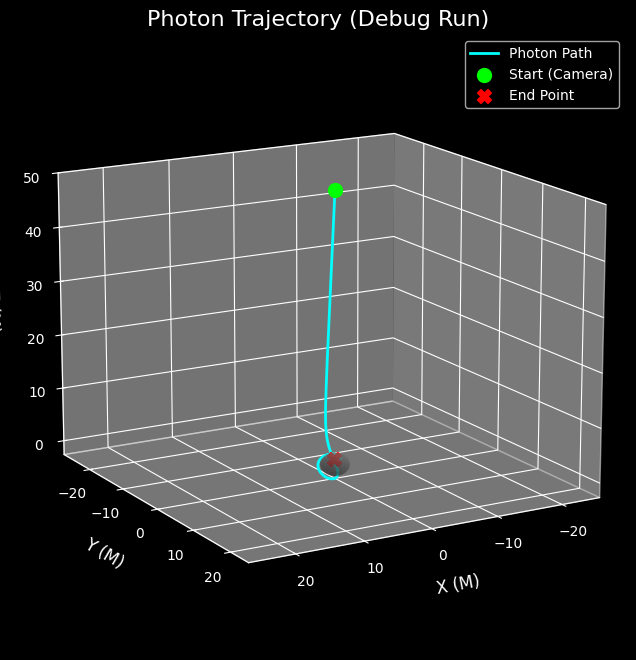

In [19]:
plot_photon_trajectory_from_debug()

# Compare blueprints

In [ ]:
# Define the paths to your two blueprint files
blueprint_t0_path = "project/photon_geodesic_integrator/light_blueprint.bin"
blueprint_t1000_path = "project/photon_geodesic_integrator/light_blueprint_0.bin"

# Run the comparison with a detailed report
are_identical = compare_blueprint_files(blueprint_t0_path, blueprint_t1000_path, detailed_report=True)

if are_identical:
    print("\nCONCLUSION: The C code is exonerated. The issue is not in the geodesic integration.")
else:
    print("\nCONCLUSION: The C code is implicated. The integration results depend on t_start, which should not happen for a stationary metric.")

# Blueprints stats

In [ ]:
# --- Call the function with your blueprint file and desired bin width ---
blueprint_filename="project/photon_geodesic_integrator/light_blueprint.bin"

analyze_blueprint()

view_binary_blueprint()

# Setting all visualization parameters

In [ ]:
import os
import numpy as np

print("--- Initializing Master Configuration for Visualization & Animation ---")

# --- Core File & Path Settings ---

# Get the user's home directory (e.g., /home/daltonm)
home_dir = os.path.expanduser('~')

# Path to the directory where the C projects live
# Assumes your notebook is in ~/Documents/
base_project_dir = os.path.join(home_dir, "Documents", "project")

# Path to the specific light integrator project
p_light_integrator_dir = os.path.join(base_project_dir, "photon_geodesic_integrator")

# --- NEW: Define the absolute output directory ---
# This will create /home/daltonm/Documents/Generated_nrpy_images/
p_output_basedir = os.path.join(home_dir, "Documents", "Generated_nrpy_images")



# --- Physics & Scene Parameters ---
p_mass_of_black_hole = 1.0
p_window_width = 1.5

# --- Source & Background Texture Settings ---
p_sphere_texture_file = "starmap_2020.png"

# --- Procedural Disk Generation Parameters ---
p_disk_inner_radius = 6.0
p_disk_outer_radius = 25.0
p_colormap = 'afmhot'
p_disk_temp_power_law = -1.5
p_ring_num = 4
p_ring_contrast = 0.7
p_ring_log_spacing = True
p_doppler_factor = 0.3
p_doppler_power = 3
p_hotspot_num = 2
p_hotspot_amplitude = 0.4
p_hotspot_radius_center = 10.0
p_hotspot_radius_width = 4.0
p_shape_num_lobes = 0
p_shape_inner_amplitude = 0.0
p_shape_outer_amplitude = 0.0
p_source_physical_width = 2 * (p_disk_outer_radius + p_shape_outer_amplitude)

# --- General Image Quality & Rendering Settings ---
p_static_image_pixel_width = 400
p_animation_pixel_width = 400
p_intensity_scale = 20.0
p_gamma = 2.2
p_lambda_min_nm = 500  # Fixed min wavelength for color consistency
p_lambda_max_nm = 2250  # Fixed max wavelength


# Path to the specific light integrator project
p_light_integrator_dir = os.path.join(base_project_dir, "photon_geodesic_integrator")
p_blueprint_filename = os.path.join(p_light_integrator_dir, "light_blueprint.bin")

# --- Animation Settings ---
p_anim_name = "detailed_spiral" # A descriptive name for this animation run
# Subfolder for the individual frames
p_anim_frames_folder = os.path.join(p_output_basedir, f"{p_anim_name}_frames")
# Subfolder for the temporary blueprints (can be deleted after)
p_anim_blueprint_folder = os.path.join(p_light_integrator_dir, f"{p_anim_name}_blueprints")
# Final output filename for the video
p_anim_video_file = os.path.join(p_output_basedir, f"{p_anim_name}.mp4")


# --- CORRECTED PATH DEFINITIONS ---

# The folder for temporary blueprints should be in the shared project directory
blueprint_folder = os.path.join(base_project_dir, f"{p_anim_name}_blueprints")

# The folder for the final PNG frames is already correctly defined in the master config
frames_folder = p_anim_frames_folder 
# --- END CORRECTION ---


p_anim_num_frames = 150
p_anim_orbits_at_isco = 2.0
p_anim_is_prograde = True
p_anim_start_time = 70.0 # The starting coordinate time for the animation

print(f"Master configuration loaded.")
print(f"All animation output will be saved in: {p_output_basedir}")

# Disk Generation

In [ ]:
source_disk_texture = generate_advanced_disk_array(
    pixel_width=1024, # High resolution for the source
    disk_physical_width=p_source_physical_width,
    colormap=p_colormap,
    disk_inner_radius=p_disk_inner_radius,
    disk_outer_radius=p_disk_outer_radius,
    disk_temp_power_law=p_disk_temp_power_law,
    ring_num=p_ring_num,
    ring_contrast=p_ring_contrast,
    ring_log_spacing=p_ring_log_spacing,
    doppler_factor=p_doppler_factor,
    doppler_power=p_doppler_power,
    hotspot_num=p_hotspot_num,
    shape_num_lobes=p_shape_num_lobes,
    shape_inner_amplitude=p_shape_inner_amplitude,
    shape_outer_amplitude=p_shape_outer_amplitude,
    display_image=False # Show the disk we're about to render
)

# Standard Static Image Generation

In [ ]:
from IPython.display import display, Image as IPImage
import os
import numpy as np

print("--- Generating a Standard Static Lensed Image from Radiative Transfer Data ---")

# --- 1. Define all inputs for the function call ---
# All parameters are now read from the master configuration cell (prefix 'p_').

# Define a unique name for the static image file
static_image_name = "batch_test_2.png"
p_static_image_pixel_width = 400
output_filename = os.path.join(p_output_basedir, static_image_name)

# Choose the source texture. This can be a filename or a pre-generated numpy array.
# For this example, we use the advanced disk generated in a previous cell.
try:
    source_image_texture = source_disk_texture
except NameError:
    print("Warning: `advanced_disk_data` not found. Generating a default disk for this static image.")
    source_image_texture = generate_advanced_disk_array(display_image=False)

# --- 2. The Function Call ---
# This call now uses all the parameters defined in your master configuration cell.
generate_static_lensed_image(
    output_filename=output_filename,
    output_pixel_width=p_static_image_pixel_width,
    source_image_width=p_source_physical_width,
    sphere_image=p_sphere_texture_file,
    source_image=source_image_texture,
    intensity_scale=p_intensity_scale,
    lambda_min_nm=p_lambda_min_nm,
    lambda_max_nm=p_lambda_max_nm,
    gamma=p_gamma,
    blueprint_filename=p_blueprint_filename,
    window_width=p_window_width
)

# --- 3. Display the result ---
if os.path.exists(output_filename):
    print(f"\nDisplaying static image: '{output_filename}'")
    display(IPImage(filename=output_filename))
else:
    print(f"\nERROR: Image file was not created at '{output_filename}'")

# Final Video Encoding

In [ ]:
# --- FINAL ANIMATION EXECUTION CELL ---

# 1. Generate the source disk texture to be used for rendering
# This is done once before the main loop.
print("--- Generating Source Disk Texture ---")
source_disk_texture = generate_advanced_disk_array(
    pixel_width=1024, # High resolution for the source
    disk_physical_width=p_source_physical_width,
    colormap=p_colormap,
    disk_inner_radius=p_disk_inner_radius,
    disk_outer_radius=p_disk_outer_radius,
    disk_temp_power_law=p_disk_temp_power_law,
    ring_num=p_ring_num,
    ring_contrast=p_ring_contrast,
    ring_log_spacing=p_ring_log_spacing,
    doppler_factor=p_doppler_factor,
    doppler_power=p_doppler_power,
    hotspot_num=p_hotspot_num,
    shape_num_lobes=p_shape_num_lobes,
    shape_inner_amplitude=p_shape_inner_amplitude,
    shape_outer_amplitude=p_shape_outer_amplitude,
    display_image=False # Show the disk we're about to render
)

# 2. Calculate animation time window
isco_radius = 6.0 * p_mass_of_black_hole
orbital_period_at_isco = 2 * np.pi * np.sqrt(isco_radius**3 / p_mass_of_black_hole)
animation_duration = orbital_period_at_isco * p_anim_orbits_at_isco
animation_end_time = p_anim_start_time + animation_duration

print(f"\nAnimation will run from t={p_anim_start_time:.2f} M to t={animation_end_time:.2f} M (Duration: {animation_duration:.2f} M).")

# --- Important: Do you want to save the light blueprints?
save_blueprints= False

# 3. Generate all the PNG frames for the animation
generate_spinning_disk_animation_frames(
    num_frames=p_anim_num_frames,
    total_animation_duration=animation_duration,
    start_time_offset=p_anim_start_time,
    project_dir=p_light_integrator_dir, # The C code still runs from its own directory
    executable_name="photon_geodesic_integrator",
    base_par_filename="photon_geodesic_integrator.par",
    blueprint_folder=blueprint_folder, # Pass the corrected, absolute path
    frames_folder=frames_folder,
    output_pixel_width=p_animation_pixel_width,
    source_image_width=p_source_physical_width,
    sphere_image=p_sphere_texture_file,
    source_image=source_disk_texture,
    window_width=p_window_width,
    gamma=p_gamma,
    lambda_min_nm=p_lambda_min_nm,
    lambda_max_nm=p_lambda_max_nm,
    intensity_scale=p_intensity_scale,
    save_blueprints= save_blueprints
)
# 4. Encode the generated frames into an MP4 video
encode_video_from_frames(
    image_folder=p_anim_frames_folder,
    output_video_path=p_anim_video_file,
    frame_rate=15
)

In [ ]:
encode_video_from_frames(
    image_folder=p_anim_frames_folder,
    output_video_path=p_anim_video_file,
    frame_rate=8
)